# Imports

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Device Configuration

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Image Transforms

In [6]:
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),          # [0,1]
])


# LOAD & EXPLORE DATASET
## Custom Dataset (No Labels) 

In [9]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# LOAD DATASET

In [10]:
# confirm the directory
import os 
print(os.listdir("/kaggle/input/product-images-dataset/small"))

['d8', '0d', '47', '17', '81', 'c5', '19', 'e2', '8f', 'a2', '22', 'cf', 'b8', '35', '92', 'b2', '50', 'c7', '23', '5b', '87', '07', 'd5', '10', 'd0', 'cd', '61', '1b', 'bf', '2e', '36', '05', '20', '06', '0f', '45', '60', '27', '6d', '64', '41', 'c8', '9e', 'da', 'ff', '89', '39', '0c', '4d', '02', '32', '98', '25', '42', 'b1', 'e5', 'b4', '52', 'f0', 'ac', 'd9', 'e0', '75', '0a', '8b', '2c', '38', '7d', '12', 'dc', 'ef', '94', '55', 'a0', 'e1', 'e7', '04', 'be', 'f1', '7e', 'ea', '49', 'fc', 'e3', 'e4', 'b9', '6e', '31', 'f9', '62', 'b6', '53', '1a', 'd2', '70', '34', '18', '4b', 'db', '79', '85', 'c2', '88', '65', '1e', '67', 'ec', 'ab', 'a3', 'a7', '78', '0e', 'd6', '28', 'f4', '66', 'cb', 'a5', 'a8', 'bc', 'e6', '56', '72', '6c', '16', '7b', 'bb', 'af', '9f', 'bd', 'ba', '13', '99', '1d', '4e', '3e', '7f', '26', 'b5', 'fb', 'd4', '4c', '74', 'b0', 'c6', '00', 'c4', '08', '15', 'ae', '90', '69', 'f8', '77', 'd1', 'f5', '3f', '9b', 'cc', '86', '95', 'f3', '43', 'ce', 'eb', '91', '3c

In [12]:

IMAGE_DIR = "/kaggle/input/product-images-dataset/small/01"

dataset = ImageDataset(IMAGE_DIR, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# VISUALIZE RANDOM IMAGES (SANITY CHECK)

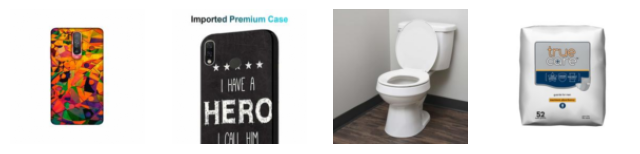

In [13]:
images = next(iter(dataloader))

plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.axis("off")
plt.show()


# DEFINE CNN AUTOENCODER (FROM SCRATCH)
## Encoder (Feature Extractor)

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 128)   # embedding vector
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


## Decoder (For Reconstruction)

In [15]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(128, 128 * 16 * 16),
            nn.ReLU()
        )

        self.deconv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x


## Autoencoder Wrapper

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


# INITIALIZE MODEL

In [19]:
model = Autoencoder().to(device)


# LOSS & OPTIMIZER

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# TRAIN THE AUTOENCODER

In [22]:
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    for images in dataloader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}")


Epoch [1/30], Loss: 6.2177
Epoch [2/30], Loss: 3.6969
Epoch [3/30], Loss: 3.0218
Epoch [4/30], Loss: 2.6691
Epoch [5/30], Loss: 2.4517
Epoch [6/30], Loss: 2.2957
Epoch [7/30], Loss: 2.1702
Epoch [8/30], Loss: 2.0116
Epoch [9/30], Loss: 1.8857
Epoch [10/30], Loss: 1.7567
Epoch [11/30], Loss: 1.6446
Epoch [12/30], Loss: 1.5548
Epoch [13/30], Loss: 1.4691
Epoch [14/30], Loss: 1.4291
Epoch [15/30], Loss: 1.3348
Epoch [16/30], Loss: 1.2461
Epoch [17/30], Loss: 1.1766
Epoch [18/30], Loss: 1.1365
Epoch [19/30], Loss: 1.1079
Epoch [20/30], Loss: 1.0584
Epoch [21/30], Loss: 1.0233
Epoch [22/30], Loss: 1.0086
Epoch [23/30], Loss: 0.9661
Epoch [24/30], Loss: 0.9214
Epoch [25/30], Loss: 0.8994
Epoch [26/30], Loss: 0.8923
Epoch [27/30], Loss: 0.8597
Epoch [28/30], Loss: 0.8526
Epoch [29/30], Loss: 0.8352
Epoch [30/30], Loss: 0.8125


# EXTRACT PRODUCT EMBEDDINGS

In [23]:
model.eval()

embeddings = []
image_names = dataset.image_files

with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        z = model.encoder(images)
        embeddings.append(z.cpu().numpy())

embeddings = np.vstack(embeddings)


# PROCESS USER-UPLOADED IMAGE

In [26]:
def process_query_image(path):
    image = Image.open(path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    return image


In [27]:
query_image = process_query_image("/kaggle/input/product-images-dataset/small/01/01013f05.jpg")

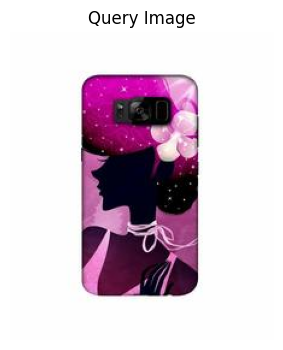

In [28]:
img = Image.open("/kaggle/input/product-images-dataset/small/01/01013f05.jpg").convert("RGB")

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title("Query Image")
plt.show()

# COMPUTE SIMILARITY

In [29]:
with torch.no_grad():
    query_embedding = model.encoder(query_image).cpu().numpy()


In [30]:
similarity = cosine_similarity(query_embedding, embeddings)

# TOP-N RECOMMENDATIONS

In [31]:
TOP_N = 5
top_indices = similarity[0].argsort()[-TOP_N:][::-1]


# SHOW RECOMMENDED IMAGES

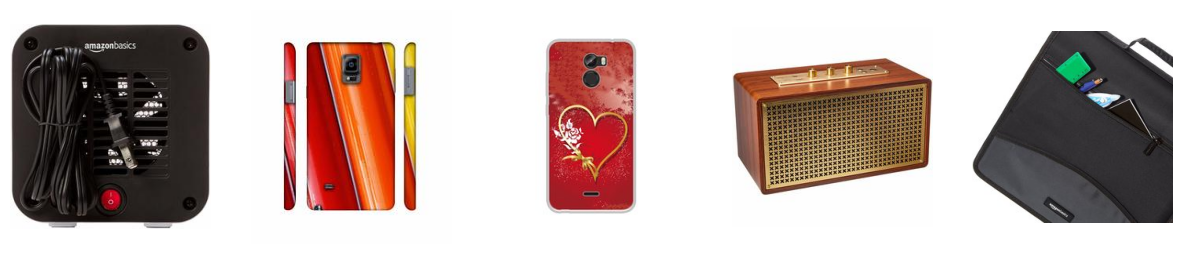

In [34]:
plt.figure(figsize=(15,5))

for i, idx in enumerate(top_indices):
    img_path = os.path.join(IMAGE_DIR, image_names[idx])
    img = Image.open(img_path)

    plt.subplot(1, TOP_N, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.show()


# New Code Here

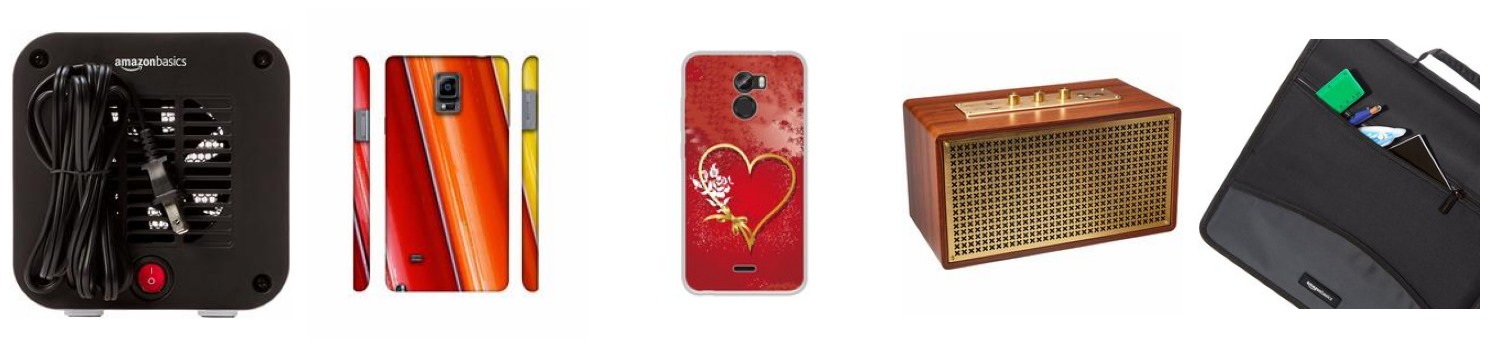

In [35]:
plt.figure(figsize=(15, 5))

for position, image_index in enumerate(top_indices, start=1):
    image_path = os.path.join(IMAGE_DIR, image_names[image_index])
    image = Image.open(image_path)

    plt.subplot(1, TOP_N, position)
    plt.imshow(image)
    plt.axis("off")

plt.tight_layout()
plt.show()
